# Performing the bilinear system identification using the split-op propagator

The propagation follows [absorbing_boundary.ipynb](https://github.com/dibondar/QuantumClassicalDynamics/blob/master/absorbing_boundary.ipynb)

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('') + '/QuantumClassicalDynamics')

from QuantumClassicalDynamics.imag_time_propagation import ImgTimePropagation, np, fftpack

from numba import njit # compile python
from scipy.signal import blackman
from scipy.linalg import eigvals
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm # enable log color plot

from collections import defaultdict

In [2]:
from bi_sys_id_quantum import estimate_rank, bi_sys_id_my_version, get_response, get_training_responses

In [3]:
# Define parameters of an atom (a single-electron model of Ar) in the external laser field

# laser field frequency
omega_laser = 0.06

# the final time of propagation (= 8 periods of laser oscillations)
t_final = 8 * 2. * np.pi / omega_laser

# amplitude of the laser field strength
F = 0.04

# the amplitude of grid
x_amplitude = 100.

# the time step
dt = 0.05

@njit
def laser(t):
    """
    The strength of the laser field.
    Always add an envelop to the laser field to avoid all sorts of artifacts.
    We use a sin**2 envelope, which resembles the Blackman filter
    """
    return F * np.sin(omega_laser * t) * np.sin(np.pi * t / t_final) ** 2

@njit
def v(x, t=0.):
    """
    Potential energy.
    
    Define the  potential energy as a sum of the soft core Columb potential
    and the laser field interaction in the dipole approximation.
    """
    return -1. / np.sqrt(x ** 2 + 1.37) + x * laser(t)

@njit
def diff_v(x, t=0.):
    """
    the derivative of the potential energy
    """
    return x * (x ** 2 + 1.37) ** (-1.5) + laser(t)

@njit
def k(p, t=0.):
    """
    Non-relativistic kinetic energy
    """
    return 0.5 * p ** 2
                                                
@njit
def diff_k(p, t=0.):
    """
    the derivative of the kinetic energy for Ehrenfest theorem evaluation
    """
    return p

@njit
def abs_boundary(x):
    """
    Absorbing boundary similar to the Blackman filter
    """
    return np.sin(0.5 * np.pi * (x + x_amplitude) / x_amplitude) ** (0.05 * dt)


sys_params = dict(
    dt=dt,
    x_grid_dim=1024,
    x_amplitude=x_amplitude,
    
    k=k,
    diff_k=diff_k,
    v=v,
    diff_v=diff_v,
    
    abs_boundary=abs_boundary,
)

In [4]:

#########################################################################
#
#   Declare the propagators
#
#########################################################################

# sys_no_abs_boundary = ImgTimePropagation(**sys_params)



sys_with_abs_boundary = ImgTimePropagation(
    **sys_params
)


# Generate responces for system identification

In [5]:
# Where the results will be saved
computed_averages = defaultdict(list)

# which observables to save
computed_averages['x_average']
computed_averages['p_average']
computed_averages['k_average']
computed_averages['v_average']
computed_averages['x_average_rhs']
computed_averages['p_average_rhs']


# system parameters without the potential energy laser field
common_sys_params = dict(
        dt=dt,
        x_grid_dim=1024,
        x_amplitude=x_amplitude,

        k=k,
        diff_k=diff_k,
        
        abs_boundary=abs_boundary,
)

# amplitude of the laser field strength
F = 0.05

@njit
def v_pulse_off(x, t=0.):
    """
    Potential energy with field off.
    """
    return -1. / np.sqrt(x ** 2 + 1.37) 

@njit
def diff_v_pulse_off(x, t=0.):
    """
    the derivative of the potential energy
    """
    return x * (x ** 2 + 1.37) ** (-1.5)

@njit
def v_pulse_on(x, t=0.):
    """
    Potential energy with field on.
    """
    return v_pulse_off(x) + x * F

@njit
def diff_v_pulse_on(x, t=0.):
    """
    the derivative of the potential energy
    """
    return diff_v_pulse_off(x) + F

# get the ground state
sys = ImgTimePropagation(
    v = v_pulse_off,
    **common_sys_params
)
sys.get_stationary_states(1)
ground_state = sys.stationary_states[0]


control_off_tsteps = 1000

for control_on_tsteps in range(1, 100):
    
    # propagate with field on
    sys = ImgTimePropagation(
        v = v_pulse_on,
        diff_v = diff_v_pulse_on,
        **common_sys_params
    ).set_wavefunction(ground_state)
    
    # save the initial point
    sys.get_ehrenfest()
    
    displaced_state = sys.propagate(control_on_tsteps)
    
    for key, val in computed_averages.items():
        val.append(getattr(sys, key))
    
    # propagate with field off
    sys = ImgTimePropagation(
        v = v_pulse_off,
        diff_v = diff_v_pulse_off,
        **common_sys_params
    ).set_wavefunction(displaced_state)

    sys.propagate(control_off_tsteps - control_on_tsteps - 1)
    
    # save the output with the fild on and off    
    for key, val in computed_averages.items():
        val[-1] += getattr(sys, key)

In [6]:
computed_averages = {key:np.array(val) for key, val in computed_averages.items()}

In [7]:
computed_averages.keys()

dict_keys(['x_average', 'p_average', 'k_average', 'v_average', 'x_average_rhs', 'p_average_rhs'])

In [72]:
#orig_responces = np.array(list(zip(*computed_averages.values())))
orig_responces = np.array(list(zip(*[
    computed_averages['x_average'], computed_averages['p_average'], computed_averages['k_average']
    # computed_averages['k_average'], computed_averages['v_average']
])))

# times of propagation
times = dt * np.arange(orig_responces.shape[-1])

In [73]:
p, m, _ = orig_responces.shape

In [74]:
orig_responces_ = orig_responces.reshape((p, 1, m, -1))

In [103]:
# perfomr the system identification
reconstructed = bi_sys_id_my_version(
    orig_responces_,
    alpha = int(orig_responces_.shape[-1] / 2),
    dt = dt,
    v = [F],
)

In [104]:
reconstructed_responses = get_training_responses(reconstructed, times=times, p=p, u=F)

In [105]:
"""
plt.title("$y^{(N)}(t)$ Input/Original Responses")
plt.plot(orig_responces.T)
plt.xlabel("Time in units of $\Delta t$")
plt.ylabel("$\\langle P \\rangle$ \t(a.u.)")
plt.savefig('input.pdf')
plt.show()


plt.title("Reconstructed responses")
plt.plot(reconstructed_responses.T)
plt.xlabel("Time in units of $\Delta t$")
plt.ylabel("$\\langle P \\rangle$ \t(a.u.)")
plt.savefig('reproduction.pdf')
plt.show()
"""

'\nplt.title("$y^{(N)}(t)$ Input/Original Responses")\nplt.plot(orig_responces.T)\nplt.xlabel("Time in units of $\\Delta t$")\nplt.ylabel("$\\langle P \\rangle$ \t(a.u.)")\nplt.savefig(\'input.pdf\')\nplt.show()\n\n\nplt.title("Reconstructed responses")\nplt.plot(reconstructed_responses.T)\nplt.xlabel("Time in units of $\\Delta t$")\nplt.ylabel("$\\langle P \\rangle$ \t(a.u.)")\nplt.savefig(\'reproduction.pdf\')\nplt.show()\n'

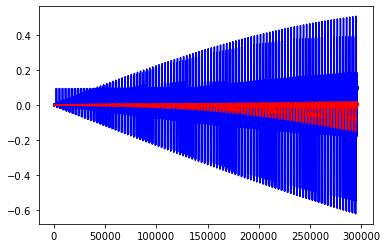

In [106]:
plt.plot(orig_responces.reshape(-1), 'b')
plt.plot(orig_responces.reshape(-1) - reconstructed_responses.reshape(-1), 'r')
#plt.xlim([0, 100])
plt.show()

In [107]:
print("error: ")
np.abs(orig_responces.reshape(-1) - reconstructed_responses.reshape(-1)).max()

error: 


0.15200433650614775

In [108]:
eigvals(reconstructed.Ac)

array([-1.21472173e-07+0.j        ,  1.03219371e-03+0.33058798j,
        1.03219371e-03-0.33058798j])

In [109]:
eigvals(reconstructed.Nc[0])

array([ 0.35696653+0.j, -1.45156307+0.j, -0.83542442+0.j])

In [110]:
computed_averages.keys()

dict_keys(['x_average', 'p_average', 'k_average', 'v_average', 'x_average_rhs', 'p_average_rhs'])

In [111]:
check_pulse = njit(lambda t: 0.5 * F * np.sin(0.06 * t))

In [112]:
response = get_response(reconstructed, check_pulse, times)

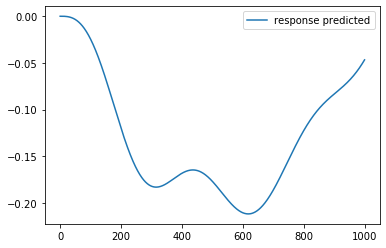

In [113]:
plt.plot(response[0], label='response predicted')
#plt.plot(check_pulse(times), label='field')
#plt.ylim([-0.1, 0.1])
#plt.xlim([0, 20])
plt.legend()
plt.show()

In [114]:
sys = ImgTimePropagation(
    v = njit(
        lambda x, t: v_pulse_off(x) + x * check_pulse(t)
    ),
    diff_v = njit(
        lambda x, t: diff_v_pulse_off(x) + check_pulse(t)
    ),
    **common_sys_params
).set_wavefunction(ground_state)

sys.propagate(times.size)

array([ 0.00000000e+00+0.00000000e+00j, -4.31345155e-09-8.22853397e-08j,
       -2.11844581e-07-6.61491148e-08j, ...,
        7.62090935e-08-7.81100172e-08j,  2.94293493e-08-4.16864609e-08j,
        1.31887329e-07-6.26488133e-08j])

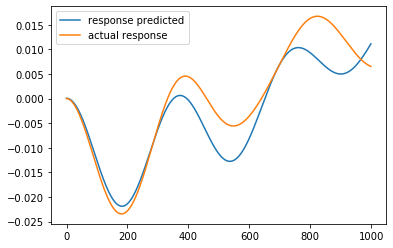

In [116]:
plt.plot(response[1], label='response predicted')
plt.plot(np.array(sys.p_average), label='actual response')
plt.legend()
plt.show()